# Part 0: Building the network 

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!


In [1]:
#importing needed libraries

import numpy as np 
import pandas as pd
import re
import json
import urllib
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import powerlaw

In [2]:
#making the dataframe from the .csv file
df_characters = pd.read_csv('ZeldaBotW_nodes_w_attributes_enriched.csv')

#extracting the names of characters from data frame
names = list(df_characters.Name)

In [3]:
#Creating our graph

path = 'Characters/'
G = nx.DiGraph()

for i in names:
    
    #reading each character's file
    with open(path + i.replace(' ', '_') + '.txt', 'r', encoding = 'utf-8') as f:
        text = f.read()
    
    #navigate through the target part of the file
    json_text = json.loads(text)
    index = list(json_text['query']['pages'].keys())[0]
    node_description = json_text['query']['pages'][index]['revisions'][0]['slots']['main']['*']
    
    #extracting the role of the character from the data frame
    role = df_characters.loc[df_characters['Name'] == i, 'Role'].values[0]
    
    #extracting race of each character using regex patterns from the character's page
    pattern = r'race= (?:(?:\{\{Term\|(?:.*?)\|(.*?)(?:\|link)?\}\})|(?:\[\[(.*?)\]\])|(.*?)(?:\\n| \{))'
    match = re.search(pattern, node_description) 
    
    #checking if race is known or unknown
    if match != None:
        for k in range(1, 4):
            if match.group(k) not in [None, ''] :
                race = match.group(k)
                break
    else:
        race = 'Unknown'

    #extracting gender of each character using regex patterns from the character's page  
    pattern = r'gender= (Unknown|Male|Female)'
    match = re.search(pattern, node_description)
    
    #cheking if gender is male, female or unknown
    if match != None:
        gender = match.group(1)
    else:
        gender = 'Unknown'
    
    #adding nodes with attributes to our graph
    G.add_nodes_from([(i, {'role': role, 'race': race, 'gender': gender})])
    
    #extracting links to ohter characters using two different regex patterns
    pattern1 = r"\[\[(.*?)(?:#(?:.*?))?(?:\|(?:.*?))?\]\]s?"
    links1 = re.findall(pattern1, node_description)
    
    pattern2 = r"\{\{(?:Term|Plural)\|BotW\|([^}|]+)(?:\|display=(?:.*?))?\|link(?:\|display=(?:.*?))?\}\}"
    links2 = re.findall(pattern2, node_description)
    
    links = links1 + links2
    
    
    #checking if the target is a character or not
    linked_characters = []
    for s in links:
        if s in names:
            linked_characters.append(s)
    
    #adding nodes to our graph
    for j in linked_characters:
        G.add_edge(i, j)

In [4]:
#extracting the isolated nodes and removing them
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)
#removing self loops
G.remove_edges_from(nx.selfloop_edges(G))

In [5]:
#extracting the largest component to make sure that we are only left with that after removing isolated nodes
largest_cc = max(nx.weakly_connected_components(G), key=len)
GCC = G.subgraph(largest_cc).copy()

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.

**Answer:**

Links in the wiki come in two different forms: with [[...]] or {{...}} so we need to define two regex patterns to extract those links. For each of these patterns, we must capture all the different ways the link can be written on the wiki page. We will explain these patterns below.

> * Show the regular expression(s) you have built and explain in details how it works.

**Pattern 1:**

In [6]:
pattern1 = r"\[\[(.*?)(?:#(?:.*?))?(?:\|(?:.*?))?\]\]s?"

##### Answer:

We use pattern 1 to extract the hyperlinks which are between the square brackets

**1)** **\\ [** : matches the character " [ "

**2)** **( )** : capturing group

**3)** **( . * ? )** :  " . " captures any character except for line terminators, " * ? " matches the previous token between 0 or more occurrences of it, as few time as possible,expanding as needed(lazy),
> * **why we use it?**: we use this pattern to catch the name of the page of the character 

**4)** **( ? : regexp )** : find but Non-capturing groupings, is denoted by " ? : "

**5)** **( ? : # ( ? : . * ? ) ) ?** : non capturing groupings, " # " catches the character " # "
> * *( ? : . * ? )* non capturing groupings again, **" ( . * ? ) "** part explained before above

> * " ? " matches the previous token between zero and one times, as many times as possible, giving back as needed (greedy)

> * **why we use it?** : we use this pattern to capture links to sections of another pages
> <br> ex: [[Link#Breath of the Wild]]

**6)** **( ? : \ | ( ? : . * ? ) ) ?** : non capturing groupings, " \\ | " catches the character " | " , 
> * *( ? : . * ? )* non capturing groupings again, **" ( . * ? ) "** part explained before above

> * " ? " matches the previous token between zero and one times, as many times as possible, giving back as needed (greedy)

> * **why we use it?** : to capture links that display something different from the name of the page > <br> ex: [[Princess Zelda|Zelda]]

**7)** **\\ ]** : matches the character " ] "

**8)** **s?** : matches the character " s " , " ? " matches the previous token between 0 and one times, as many times as possible, giving back as needed (greedy) 
> * **why we use it?** : to capture links using plural terms
> <br> ex: [[Heart]]s

**Pattern 2:**

In [7]:
pattern2 = r"\{\{(?:Term|Plural)\|BotW\|([^}|]+)(?:\|display=(?:.*?))?\|link(?:\|display=(?:.*?))?\}\}"

##### Answer:

We use pattern 2 to extract the hyperlinks which are between the curly brackets

**1)** **\\ {** : matches the character " { "

**2)** **( ? : Term | Plural )** : find but non capturing group, for this pattern (Term|Plural)

**3)** **\\ |** : matches the character " | "

**4)** **BotW** : matches the characters BotW

**5)** **( [ ^ } |] + )** : matches everything except " } " and " | "
> * " + " matches the previous token between one and unlimited times, as many times as possible, giving back as needed (greedy)
> * **why we use it?** : we use this pattern to catch the name of the page of the character
> <br> - " } " : We want to exclude links that don't end with "link}}"
> <br> ex: "{{Term|BotW|**Ashai}}, but tells {{Term|BotW|Baddek**|link}}" (the bold part of this text would be returned as a page name if we didn't exclude " } "
> <br> - " | " : We want to exclude the "|display= " part of the link from the page name
> <br> ex: "{{Term|BotW|Princess Zelda|display=Zelda|link}}"

**6)** **( ? : \ | display = ( ? : . * ? ) ) ?** : non capturing group, matches the character " | " , matches display= , non captuting group of (.*?) which is explained above, " ? " matches the previous token between zero and one times, as many times as possible, giving back as needed (greedy)

**7)** **link** matches the "link"

**8)** **( ? : \ | display= ( ? : . * ? ) ) ?** : explained above

**NOTE** : we use part 6 & 8 because the display part can either be before "link" or after it

**9)** **\\ }** : matches the character " } "

# Part 1: Network visualization and basic stats

Visualize the network (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you've already generated the BotW network and extracted the giant connected component. Use the GCC to report the results.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 


In [8]:
print("\n\033[1m" + "Answer:\n" + "\033[0m")
print(f'Number of Nodes are:\n {GCC.number_of_nodes()}')


Answer:

Number of Nodes are:
 530


> * What is the number of links?

In [9]:
print("\n\033[1m" + "Answer:\n" + "\033[0m")
print(f'Number of Links are:\n {GCC.number_of_edges()}')


Answer:

Number of Links are:
 1620


> * Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [10]:
#extracting the maximum total degree and its respective node
k_max = max(dict(GCC.degree).values())
top_node = [i for i, k in GCC.degree if k == k_max]

#extracting the maximum in_degree and its respective node
k_in_max = max(dict(GCC.in_degree).values())
top_node_in = [i for i, k in GCC.in_degree if k == k_in_max]

#extracting the maximum out_degree and its respective node
k_out_max = max(dict(GCC.out_degree).values())
top_node_out = [i for i, k in GCC.out_degree if k == k_out_max]

In [11]:
print("\n\033[1m" + "Answer:\n" + "\033[0m")
print(f'top connected character in terms of total degree is "{top_node[0]}" and its degree is {k_max}.\n')
print(f'top connected character in terms of in_degree is "{top_node_in[0]}" and its in_degree is {k_in_max}.\n')
print(f'top connected character in terms of out_degree is "{top_node_out[0]}" and its out_degree is {k_out_max}.')


Answer:

top connected character in terms of total degree is "Link" and its degree is 404.

top connected character in terms of in_degree is "Link" and its in_degree is 395.

top connected character in terms of out_degree is "Traysi" and its out_degree is 14.


*Findings:*

Link is the character who has the highest total degree and in-degree which is what we could have expected because he is the hero of the game, so he should be the character who is the most refered to (highest in-degree) and a character who refers to a lot of other characters. Traysi is a journalist so we can understand why she has the highest out-degree, since her job makes her meet a lot of characters who therefore will be mentionned on her page. 

> * Who are the top 5 most connected allies (again in terms of in/out-degree)?

In [12]:
#making a sorted dictionary of 'total', 'in' and 'out' degrees
#extracting the top five most connected in each of the dictionaries

sorted_dic = sorted(dict(GCC.degree).items(), key=lambda item: item[1], reverse = True)
top_allies = [k for k, v in sorted_dic if GCC.nodes[k]['role'] == 'Ally'][:5]

sorted_dic_in = sorted(dict(GCC.in_degree).items(), key=lambda item: item[1], reverse = True)
top_allies_in = [k for k, v in sorted_dic_in if GCC.nodes[k]['role'] == 'Ally'][:5]

sorted_dic_out = sorted(dict(GCC.out_degree).items(), key=lambda item: item[1], reverse = True)
top_allies_out = [k for k, v in sorted_dic_out if GCC.nodes[k]['role'] == 'Ally'][:5]

In [13]:
print("\n\033[1m" + "Answer:\n" + "\033[0m")
print(f'top 5 most connected allies in terms of total degree are:\n {top_allies}\n')
print(f'top 5 most connected allies in terms of in_degree are:\n {top_allies_in}\n')
print(f'top 5 most connected allies in terms of out_degree are:\n {top_allies_out}')


Answer:

top 5 most connected allies in terms of total degree are:
 ['Link', 'Hylia', 'Princess Zelda', 'Riju', 'Mipha']

top 5 most connected allies in terms of in_degree are:
 ['Link', 'Hylia', 'Princess Zelda', 'Riju', 'Mipha']

top 5 most connected allies in terms of out_degree are:
 ['Traysi', 'Daruk', 'Genli', 'Dorian', 'Link']


> * Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?

In [14]:
#extracting the top five most connected enemies in each of the 'total', 'in' and 'out' degrees 

top_enemies = [k for k, v in sorted_dic if GCC.nodes[k]['role'] in ['Enemy', 'Boss']][:5]
top_enemies_in = [k for k, v in sorted_dic_in if GCC.nodes[k]['role'] in ['Enemy', 'Boss']][:5]
top_enemies_out = [k for k, v in sorted_dic_out if GCC.nodes[k]['role'] in ['Enemy', 'Boss']][:5]

In [15]:
print("\n\033[1m" + "Answer:\n" + "\033[0m")
print(f'top 5 most connected enemies in terms of total degree are:\n {top_enemies}\n')
print(f'top 5 most connected enemies in terms of in_degree are:\n {top_enemies_in}\n')
print(f'top 5 most connected enemies in terms of out_degree are:\n {top_enemies_out}')


Answer:

top 5 most connected enemies in terms of total degree are:
 ['Calamity Ganon', 'Bokoblin', 'Lizalfos', 'Stalizalfos', 'Silver Lizalfos']

top 5 most connected enemies in terms of in_degree are:
 ['Calamity Ganon', 'Bokoblin', 'Lizalfos', 'Blue Bokoblin', 'Stalizalfos']

top 5 most connected enemies in terms of out_degree are:
 ['Stalizalfos', 'Lizalfos', 'Silver Lizalfos', 'Moblin', 'Lynel']


> * Plot the in- and out-degree distributions. 

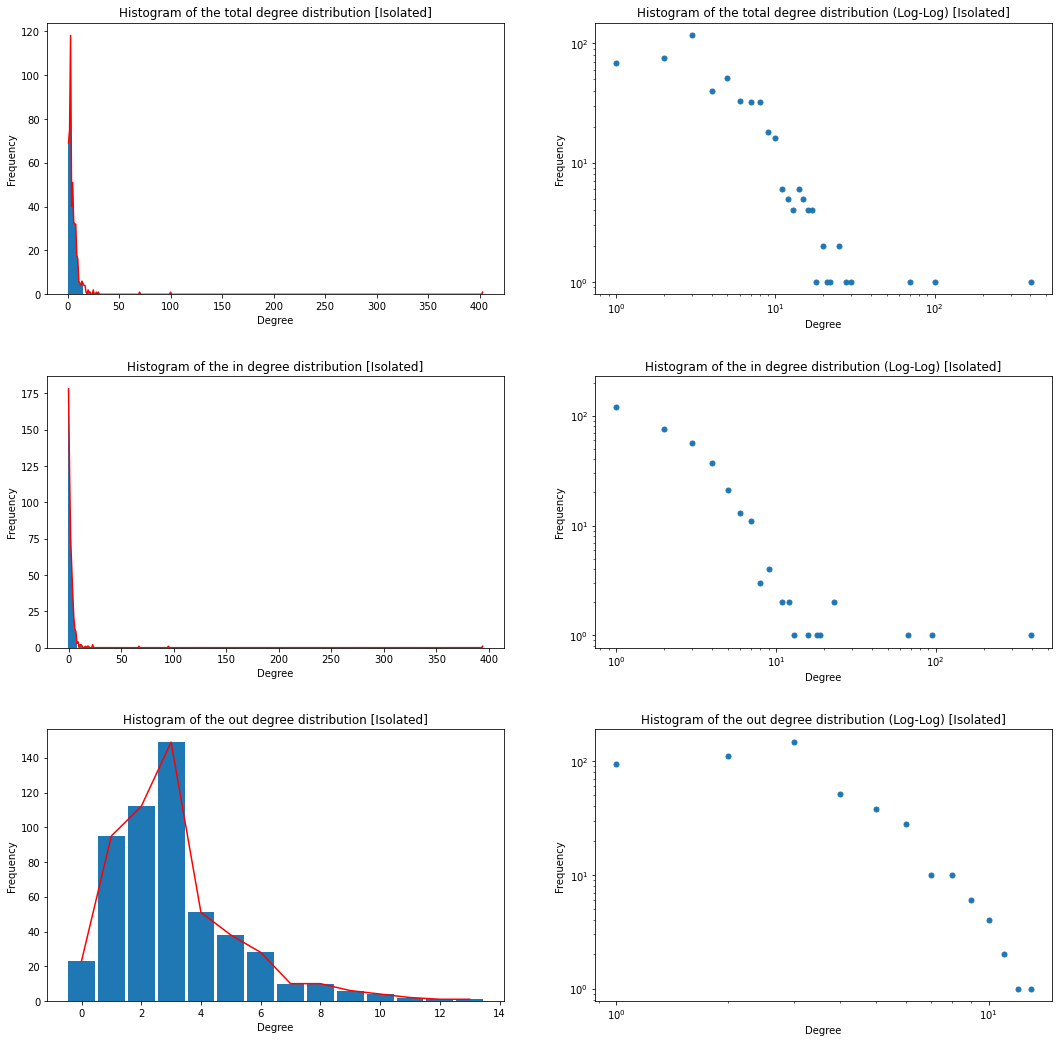

In [16]:
#sns.set()
degreeViews = [GCC.degree, GCC.in_degree, GCC.out_degree]
str_titles = ['total', 'in', 'out']
titles = [['Histogram of the {} degree distribution [Isolated]'.format(s), 'Histogram of the {} degree distribution (Log-Log) [Isolated]'.format(s)] for s in str_titles]

f, axs = plt.subplots(3, 2, figsize=(18, 18) )
plt.subplots_adjust(hspace = 0.3)

for i in range(3):
    degrees = list(dict(degreeViews[i]).values())
    k_max = np.max(degrees)
    k_min = np.min(degrees)
    v = np.array([i for i in range (k_min, k_max + 1)])
    counts, bins = np.histogram(degrees, bins=v)  
    
    for j in [0, 1]:
        if j == 0:
            axs[i, j].bar(bins[:-1], counts, width = 0.9)
            axs[i, j].plot(bins[:-1], counts, 'r')
        else:
            axs[i, j].plot(bins[:-1], counts, 'o', markersize=5)
        axs[i, j].set_ylabel('Frequency')
        axs[i, j].set_xlabel('Degree')
        axs[i, j].set_title(titles[i][j])

    axs[i, 1].set_xscale('log')
    axs[i, 1].set_yscale('log')

>   * What do you observe? 
>   * Can you explain why the in-degree distribution is different from the out-degree distribution?


##### Answer:
We can see that the in-degree distribution is similar to the total degree distribution. The out-degree distribution has a smaller range of degrees (the maximum degree is one order of magnitude smaller than for the in-degree or total degree distribution). Considering that the out-degree of a character is the number of times a character's page links to another character, whereas the in-degree of a character is the number of other characters that link to the character's page, important characters (hubs) will have a high in-degree. This explains why the in-degree distribution has higher values. 

> * Find the exponent of the degree distribution (by using the `powerlaw` package) for the in- and out-degree distribution. What does it say about our network?

In [17]:
print('Degree exponent for:\n')

#calculating the degree exponent for "in" and "out" degree distribution
print(' \033[1m in-degree: \033[0m ', powerlaw.Fit(list(dict(GCC.in_degree).values())).alpha)
print(' \033[1m out-degree: \033[0m ', powerlaw.Fit(list(dict(GCC.out_degree).values())).alpha)

Degree exponent for:

Calculating best minimal value for power law fit
  in-degree:   3.2486491538500637
Calculating best minimal value for power law fit
  out-degree:   4.381980419561967


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


**Asnwer**:

The degree distributions are in the random regime because their degree exponent is greater than 3. It means that our network is indistiguishable from a random network. 
This is surprising, because when we look at the in degree distribution, it seems like a powerlaw so it seems like the network should be scale free.
Actually, this can be explained by the fact that the in-degree exponent is really close to 3, so it is nearly a scale-free regime.



> * Compare the degree distribution of the undirected graph to a *random network* with the same number of nodes and probability of connection *p*. Comment your results.

In [18]:
#convert our graph to an undirected graph
H = nx.Graph(GCC)

In [19]:
#creating a random graph with the same number of nodes and probability of connection p
N = H.number_of_nodes()
L = H.number_of_edges()
p = L/(N*(N - 1))

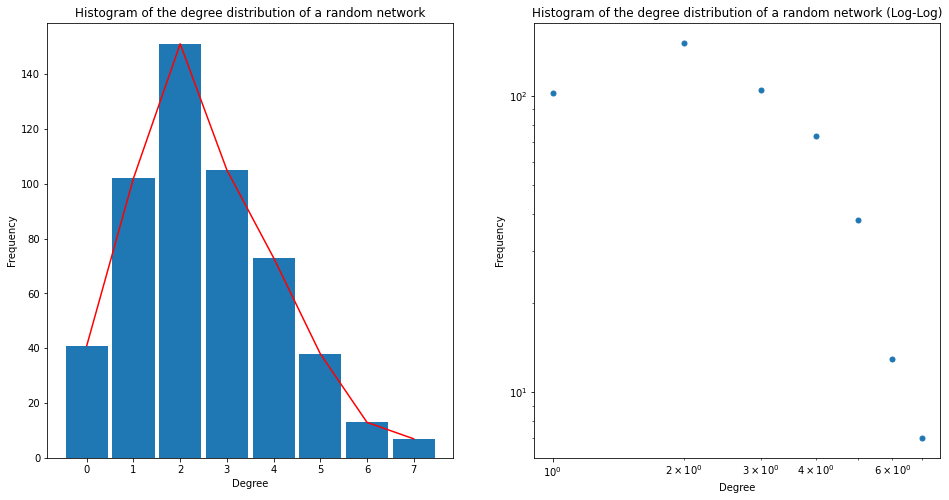

In [20]:
H_random = nx.gnp_random_graph(N, p)


network = H_random
str_title = 'random'
titles = ['Histogram of the degree distribution of a random network', 'Histogram of the degree distribution of a random network (Log-Log)']
f, axs = plt.subplots(1, 2, figsize=(16, 8))
plt.subplots_adjust(hspace = 0.3)


degrees = list(dict(network.degree).values())
k_max = np.max(degrees)
k_min = np.min(degrees)
v = np.array([i for i in range (k_min, k_max + 1)])
counts, bins = np.histogram(degrees, bins=v)  
    
for j in [0, 1]:
    if j == 0:
        axs[j].bar(bins[:-1], counts, width=0.9)
        axs[j].plot(bins[:-1], counts, 'r')
    else:
        axs[j].plot(bins[:-1], counts, 'o', markersize=5)
    axs[j].set_ylabel('Frequency')
    axs[j].set_xlabel('Degree')
    axs[j].set_title(titles[j])

axs[1].set_xscale('log')
axs[1].set_yscale('log')

##### Answer:

The Out-degree distribution look like the distribution of a random network with the same number of nodes and same *p*. 

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (undirected) network:
>   * Color nodes according to the role;

In [21]:
#create a Dataframe of the GCC for convenience
graphchars = df_characters[~df_characters['Name'].isin(isolated)]
gccdf = graphchars[graphchars['Name'].isin(list(GCC.nodes))]

# Creating the map of colors for the nodes of the network
colormaprole=["yellow" if H.nodes[n]['role'] == 'Boss' else "red" if H.nodes[n]['role'] == 'Enemy' else "blue" for n in H.nodes]

>   * Scale node-size according to degree;

In [22]:
# Creating the map of sizes for the nodes of the network
sizemap  = [x * 10 for x in list(dict(H.degree()).values())]

>   * Get node positions based on the Force Atlas 2 algorithm;

In [23]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)

# Getting the positions of the nodes from forceatlas2
positions = forceatlas2.forceatlas2_networkx_layout(H, pos=None, iterations=2000)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 190.06it/s]

BarnesHut Approximation  took  2.69  seconds
Repulsion forces  took  6.98  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.45  seconds


>   * Whatever else you feel like that would make the visualization nicer.

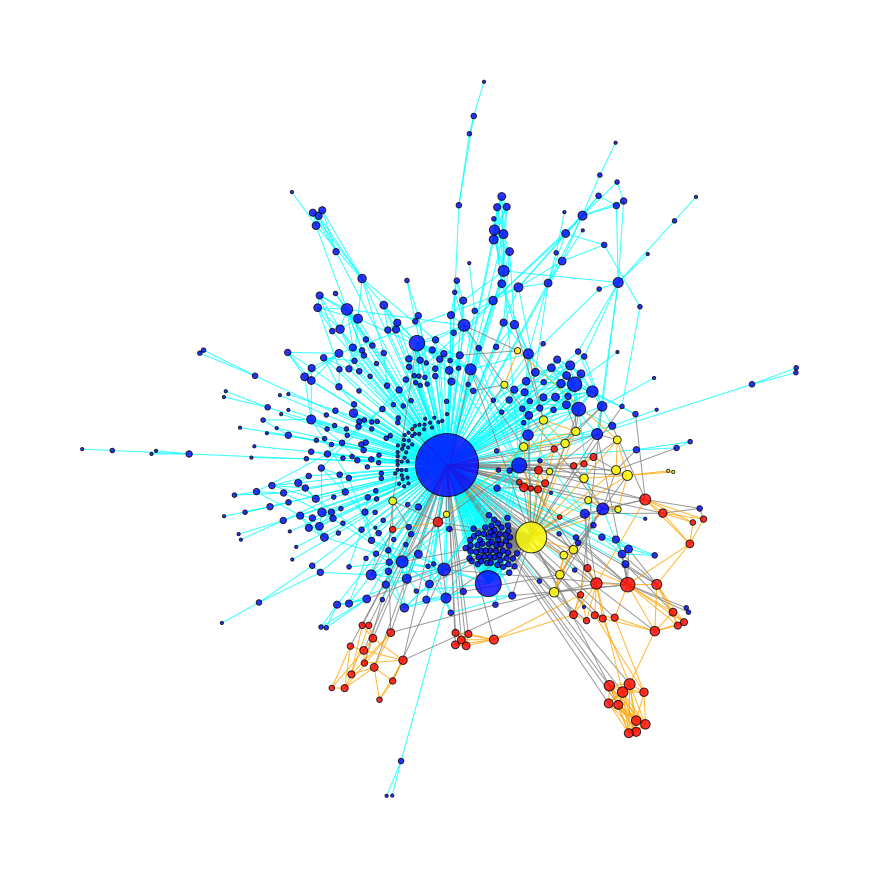

In [24]:
# Creating the map of colors for the edges of the network
edgecolors=[]
for i,v in H.edges:
    role1 = gccdf.loc[gccdf.Name==i, 'Role'].iloc[0]
    role2 = gccdf.loc[gccdf.Name==v, 'Role'].iloc[0]
    if (role1 == role2) and (role2 == 'Ally'):
        edgecolors.append('cyan')
    elif role1 != role2 :
        edgecolors.append('grey')
    else:
        edgecolors.append('orange')

# Plot our graph with the new node postions gained from forceatlas2
plt.figure(figsize = (12, 12))
nx.draw(H, positions, node_size=sizemap, with_labels=False, node_color=colormaprole, edge_color = edgecolors, node_shape='o', alpha=0.8, edgecolors = 'black')

> * Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

**ANSWER:** 

We can see that the generated graph is a fully connected Graph, as we are presenting the largest component (GCC) of the original graph. In terms of topology, the hubs of this network are located in the center. Additionally, we can see that many clusters of same-Role nodes exist(as most links are not grey). Also, we can observe a chain of connected nodes. Between the three largest nodes, are located some small nodes, that are connected directly with the three biggest nodes. We can guess that the biggest nodes ( those who have the biggest degree), are the main characters of the game (i.e the hero, the final Boss, a friend/guide). So the biggest node of an Ally at the center of the network is Link, whereas the biggest node of a Boss is Calamity Ganon. The third biggest node is Hylia which is a goddess, so she is important for a lot of characters in the game.

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the ZeldaWiki pages.

Here's what you need to do:
> * Create a word-cloud for each race of the [five champions of Hyrule](https://zelda.fandom.com/wiki/Champions) (i.e. Hylian, Zora, Goron, Gerudo, and Rito) according to either TC-IDF. Feel free to make it as fancy as you like. Explain your process and comment on your results.

In [25]:
import nltk, re, pprint
from nltk import word_tokenize
import matplotlib.pyplot as plt
from matplotlib import style
#style.use('dark_background')
import pandas as pd
import numpy as np

In [26]:
dfrace = df_characters.groupby('Race')
champion_races = [ "Hylian", "Zora", "Goron", "Gerudo", "Rito"]
champion_races_word = [[] for _ in range(len(champion_races))]
for i in range(len(champion_races)):
    #Make the text lowercase
    ilower = champion_races[i].lower()
    
    safull = ""
    for j in dfrace.get_group(champion_races[i]).Name:
        j = j.replace(" ","_")
        filename = "Preprocessing\\" + j + ".txt"
        with open(filename, 'r', encoding='utf-8') as outfile:
            sa=outfile.read()
            
        # Delete the race word (i.e Gerudo) from the lexicon of that individual race(i.e Gerudo race).
        sa = sa.replace(ilower, '')
        safull = safull + sa
    #Creating a list of lists. Every list contains the words from all characters of this Race
    champion_races_word[i] = safull

In [27]:
#This function gets a document and returns the TF of that
def getTF(document):
    document_set = [list(set(d)) for d in document]
    TF = []
    for i in range(len(document)):
        fdist = nltk.FreqDist(document[i])
        TF.append([fdist[w]/len(fdist) for w in document_set[i]]) 
    return TF;

#This function gets a document and returns the TC of that
def getTC(document):
    document_set = [list(set(d)) for d in document]
    TC = []
    for i in range(len(doc)):
        fdist = nltk.FreqDist(document[i])
        TC.append([fdist[w] for w in document_set[i]]) 
    return TC;
   
# This function gets a document and returns the IDF of that
def getIDF(document):
    document_set = [list(set(d)) for d in document]
    N = len(document)
    IDF = []
    for i in range(N):
        IDF_i = []
        for t in document_set[i]:
            n_t = sum([1 for d in document if t in d])
            IDF_i.append(np.log10(N/n_t))
        IDF.append(IDF_i)
    return IDF;


In [28]:
import nltk

# create a tokenizer to get the words in text
# We are using Regexptokenizer beacause it combines the exclution of punctuation and stop words
tokenizer = nltk.RegexpTokenizer(r"\w+")

# create a list with the races we are interested in
champion_races = [ "Hylian", "Zora", "Goron", "Gerudo", "Rito"]

# Creating a DataFrame containing the characters of Zelda Botw an
df_characters = pd.read_csv('ZeldaBotW_nodes_w_attributes_enriched.csv')
names = df_characters.Name

#raceNames = np.unique(df_characters.Race)
raceDict = dict(zip(champion_races, range(len(champion_races))))

count = 0
doc = [[] for _ in range(len(champion_races))]
N = len(doc)

for i in range(len(champion_races_word)):
    sa4 = tokenizer.tokenize(champion_races_word[i])
    doc[i] += sa4
doc_set = [list(set(d)) for d in doc]

# Calculate the TF, TC and IDF
TF = getTF(doc)
TC = getTC(doc)
IDF = getIDF(doc)

# Calculate the TC-IDF and TF-IDF
TF_IDF = [[TF[i][j]*IDF[i][j] for j in range(len(doc_set[i]))] for i in range(N)]
TC_IDF = [[TC[i][j]*IDF[i][j] for j in range(len(doc_set[i]))] for i in range(N)]

Hylian


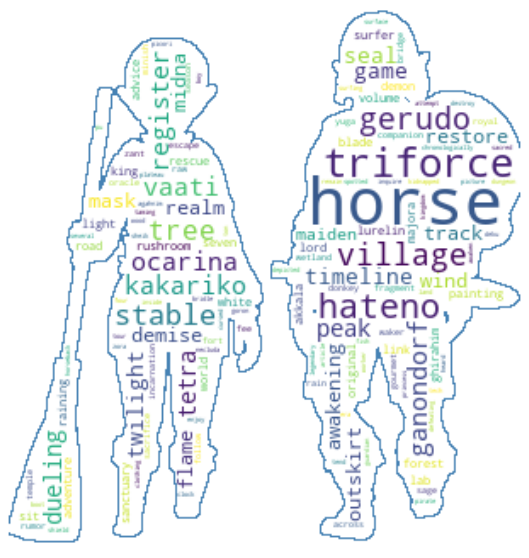

Zora


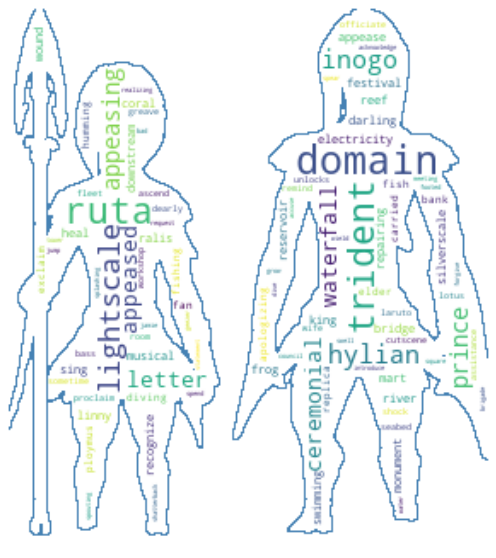

Goron


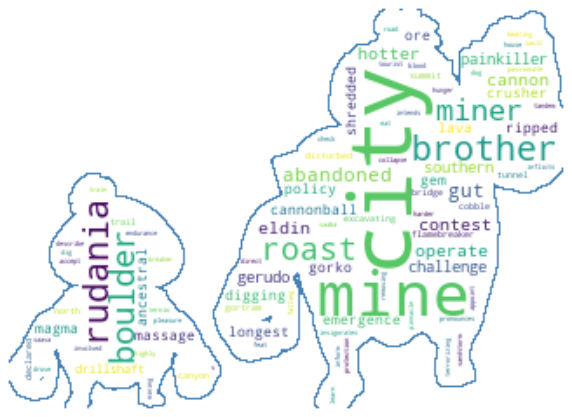

Gerudo


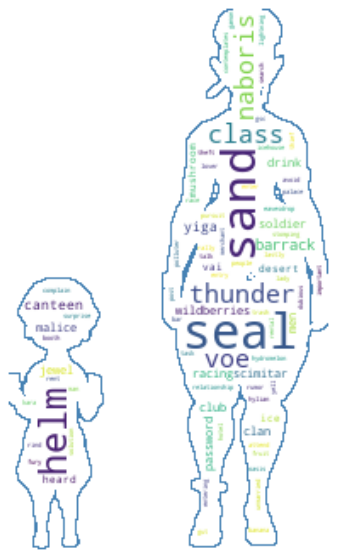

Rito


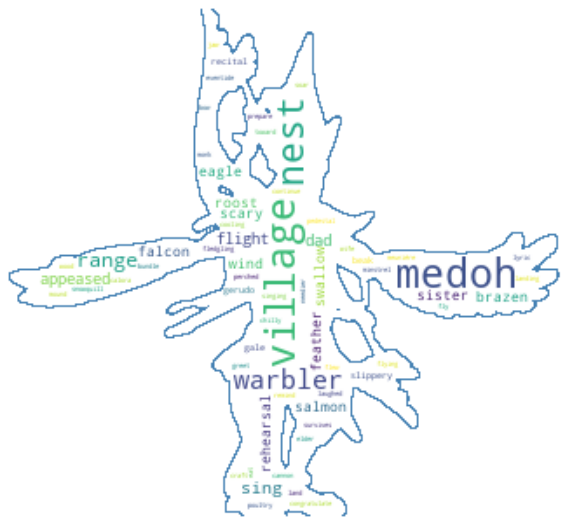

In [29]:
#importing the libraries needed
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# create the list of the doc list for convenience
doc_set = [list(set(d)) for d in doc]

#Creating a list with the text of every race file, by first creating the words list
words = [[doc_set[i][j] for j in range(len(doc_set[i])) for _ in range(int(np.ceil(TC_IDF[i][j])))] for i in range(N)]
texts = [' '.join(words[i]) for i in range(N)]

#The names of champion races in a list
champion_races = ["Hylian", "Zora", "Goron", "Gerudo", "Rito"]

#Iterate through the champion races
for i in range(len(champion_races)):
    print(champion_races[i])
    
    #create a  mask for our wordCloud, by opening the images we  downloaded processed and stored for each of the champion races
    mask = np.array(Image.open("Images/" + champion_races[i] + '.png'))
    
    #call the WordCloud with all the adjusted parameters and store it
    wc = WordCloud(stopwords=STOPWORDS,
               mask=mask, background_color='white',
               max_words=2000, max_font_size=50,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0],contour_width=1, contour_color='steelblue', collocations=False)
    
    #Creating the wordcloud of the race text
    wc.generate(texts[i])
    
    #Plotting the Wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Part 3: Communities and TF-IDF

Find communities and compute their associated TF-IDF (from lecture 7 and 8).

Here's what you need to do:
> * Explain the Louvain algorithm and how it finds communities in a newtork.






**ANSWER**: 

The Louvain algorithm is a sophisticated solution to detect communities in a network. It detects the communities, while optimizing their modularity score, as a result the created communities are very well connected.

The way the algorithm works is the following.
It recursively merges communities into a single node and executes the modularity clustering on the condensed graphs.
It detects small communities of the network, and try to optimize their modularity score. After that, it summarizes that small community to a single node, and continues doing the same steps for the whole network.



> * Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works) 

In [30]:
import community
partition = community.best_partition(H)

**ANSWER**: 

We chose to identify the communities by using the Louvain method, which works as described above. It is a very good algorithm in cmmunity detection and it worked better (in modularity) than some other simple algorithms we tried.

> * Comment your results:
>   * How many communities did you find in total?

In [31]:
print("\033[1m" + "ANSWER" + "\033[0m"+ ":\n The number of communities in the network is", len(set(partition.values())))

ANSWER:
 The number of communities in the network is 22


>   * Compute the value of modularity with the partition created by the algorithm.

In [32]:
M_louvain = community.modularity(partition, H)
print("\033[1m" + "ANSWER" + "\033[0m"+ ":\n The value of modularity of the created partition is:", M_louvain)

ANSWER:
 The value of modularity of the created partition is: 0.5762795267078663


>   * Plot the distribution of community sizes.

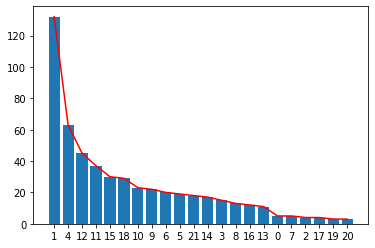

In [33]:
#create a dictionary with keys the community name, and values, the list of nodes it contains
res = {}
for i, v in partition.items():
    res[v] = [i] if v not in res.keys() else res[v] + [i]
    
    #print(i, v)
    
#create a dictionary with the community and the number of nodes
resnum = {}
for k, v in res.items():
    resnum[k] = len(v)
    
#sort the previous dictionary
resnum = {k: v for k, v in sorted(resnum.items(), key=lambda item: item[1], reverse = True)}

#get the names and values of the dictionary in lists
names = list(resnum.keys())
values = list(resnum.values())


#plot the sorted values to a histogram
plt.bar(range(len(resnum)),values, tick_label=names)
plt.plot(range(len(resnum)),values, 'r')
plt.show()

**ANSWER**: 

The provided plot bar shows us the number of nodes  in each of the 22 communities in descending order. We can see that the biggest community has more than double the nodes of the others, and the values decrease gradually.

Summarizing, we can see from the distribution of community sizes that the communities are not much equally distributed. This is much expected in a social graph, as the communities in general are unequal in size. It seems that we have 3 big communities (more than 40 nodes), then many medium size communities (15- 40 nodes), and some small communities (less than 15 nodes)


> * For the 5 largest communities, create TF-IDF based rankings of words in each community. 
>   * There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.


**ANSWER**:

We calculated TF-IDF and TC-IDF too, by simply multiplying the values of TF and IDF for the first one, and the values of TC and IDF for the latter one. 

We chose the "simple" TF-IDF formula, because it is the simplest one, with good results and it is also the most widely used method.

In [34]:
TFcomm = getTF(doc)
TCcomm = getTC(doc)
IDFcomm = getIDF(doc)
TF_IDFcomm = [[TFcomm[i][j]*IDFcomm[i][j] for j in range(len(doc_set[i]))] for i in range(N)]
TC_IDFcomm = [[TCcomm[i][j]*IDFcomm[i][j] for j in range(len(doc_set[i]))] for i in range(N)]

>   * List the 5 top words for each community according to TF.


In [35]:
# A function that takes as argument a TF-like matrix and returns the top 5 words
def getTop5(TForIDF):
    top5 = []
    for i in range(len(TForIDF)):
        l = TForIDF[i]
        indices = sorted(range(len(l)), key = lambda sub: l[sub], reverse=True)[:5]
        l_max = [doc_set[i][j] for j in indices]
        top5.append(l_max)
    return top5;

In [36]:
# ordinal calculated  by this ref https://stackoverflow.com/questions/9647202/ordinal-numbers-replacement
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
top5tf = getTop5(TFcomm)
print("\033[1m" + "ANSWER" + "\033[0m"+ ":")
for i in range(len(top5tf)):
    print("\nThe top 5 words used in the", ordinal(i+1), "largest community, according to TF are", top5tf[i])
    

ANSWER:

The top 5 words used in the 1st largest community, according to TF are ['zelda', 'stable', 'hyrule', 'wild', 'horse']

The top 5 words used in the 2nd largest community, according to TF are ['domain', 'ruta', 'beast', 'divine', 'vah']

The top 5 words used in the 3rd largest community, according to TF are ['city', 'vah', 'rudania', 'brother', 'breath']

The top 5 words used in the 4th largest community, according to TF are ['town', 'say', 'tell', 'speaks', 'asks']

The top 5 words used in the 5th largest community, according to TF are ['village', 'medoh', 'breath', 'wild', 'beast']


>   * List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.

In [37]:
top5tfidf = getTop5(TF_IDFcomm)
print("\033[1m" + "ANSWER" + "\033[0m"+ ":")
for i in range(len(top5tfidf)):
    print("\nThe top 5 words used in the", ordinal(i+1), "largest community, according to TF-IDF are", top5tfidf[i])

ANSWER:

The top 5 words used in the 1st largest community, according to TF-IDF are ['horse', 'triforce', 'hateno', 'gerudo', 'village']

The top 5 words used in the 2nd largest community, according to TF-IDF are ['domain', 'ruta', 'trident', 'lightscale', 'inogo']

The top 5 words used in the 3rd largest community, according to TF-IDF are ['city', 'mine', 'rudania', 'brother', 'boulder']

The top 5 words used in the 4th largest community, according to TF-IDF are ['seal', 'sand', 'voe', 'helm', 'thunder']

The top 5 words used in the 5th largest community, according to TF-IDF are ['medoh', 'village', 'nest', 'warbler', 'range']


# Part 4: Sentiment of communities

Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities.  More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

Here's what you need to do (repeat these steps and report your results for **both LabMT and VADER**):
> * Calculate and store sentiment for every character
> * Create a histogram of all character's associated sentiments.
> * What are the 10 characters with happiest and saddest pages?


## LabMT

> * Calculate and store sentiment for every character

In [38]:
from nltk import word_tokenize
# Here the dataset should be downloaded in the same folder as the notebook
df = pd.read_csv('Data_Set_S1.txt', sep = '\t', header = 2)

# We use the first tip for speed: we look for the happiness score of each unique word in the tokens
# and do a weighted mean using the frequency distribution
def sentiment(tokens):
    fdist = nltk.FreqDist(tokens)
    # We want the sentiment of the words that are in the tokens AND that are in Data Set S1
    happiness = [float(df.loc[df.word == w, 'happiness_average']) for w in dict(fdist).keys() 
                 if w in list(df.word)]
    freq = [fdist[w] for w in dict(fdist).keys() if w in list(df.word)]
    return np.average(happiness, weights = freq)


f = open('CharactersDialogue.json')
data = json.load(f)

def tokenize(sentence):
    tokens = nltk.wordpunct_tokenize(sentence)
    wnl = nltk.WordNetLemmatizer()
    return [wnl.lemmatize(t.lower()) for t in tokens if t.isalnum()]

# We store the sentiment of each node in a dictionnary
dic = {}
for node in H.nodes:
    if node in data.keys():
        tokens = [t for sentence in data[node] for t in tokenize(sentence)]
        s = sentiment(tokens)
        dic[node] = s

> * Create a histogram of all character's associated sentiments.

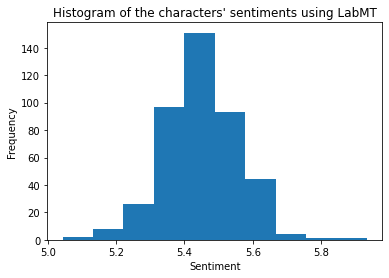

In [39]:
plt.hist(dic.values(), align = 'left')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
_=plt.title("Histogram of the characters' sentiments using LabMT")

In [40]:
print('The happiness average in Data Set S1 is', df.happiness_average.mean())

The happiness average in Data Set S1 is 5.375239679123416


**ANSWER**:

The characters' sentiments seem normally distributed around 5.45, which is a little bit happier than the average hapiness of all the words in Data Set S1.

> * What are the 10 characters with happiest and saddest pages?

In [41]:
# We first sort the dictionary of nodes and their sentiments by the sentiment and store it in 
# the form of a list of tuples
sorted_dic = sorted([(u, v) for u, v in dic.items() if v], key = lambda item: item[1])
# We take only the characters' names
sorted_list = [u for u, v in sorted_dic]

# The 10 saddest and happiest pages are ordered in an ascending order (the saddest/happiest 
# character is the last)
saddest = sorted_list[10:0:-1]
happiest = sorted_list[-10::]

print('The 10 saddest characters are:')
print(saddest)
print('\nThe 10 happiest characters are:')
print(happiest)

The 10 saddest characters are:
['Nobiro', 'Sudrey', 'Flaxel', 'Laine', 'Strade', 'Bargoh', 'Palme', 'Walton', 'Kotta', 'Kenyo']

The 10 happiest characters are:
['Cecili', 'Kayden', 'Notts', 'Zyle', 'Chessica', 'Toren', 'Kula', 'Shamae', 'Narah', 'Kinov']


## VADER

> * Calculate and store sentiment for every character

In [42]:
# We store the first 3 columns of the vader lexicon in a dataframe 
df_vader = pd.read_csv('vader_lexicon.txt', sep = '\t', header = None, usecols = [0, 1, 2])

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# We store the polarity of the characters in a dictionary by computing the mean polarity
# of all the sentences in the dialogue of a character
dic_vader = {node: np.mean([analyzer.polarity_scores(sentence)['compound'] 
                            for sentence in data[node]]) for node in data.keys()}

> * Create a histogram of all character's associated sentiments.

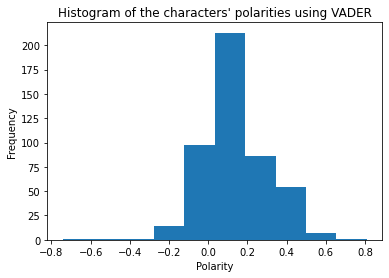

In [43]:
plt.hist(dic_vader.values(), align = 'left')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
_=plt.title("Histogram of the characters' polarities using VADER")

In [44]:
print('The polarity average in VADER lexicon is', df_vader[1].mean())

The polarity average in VADER lexicon is -0.17892287234042592


The characters' polarities seem to be normally distributed around 0.1 which is a little bit happier than the average polarity of the VADER lexicon.

> * What are the 10 characters with happiest and saddest pages?

In [45]:
# We first sort the dictionary of nodes and their sentiments by the sentiment and store it in 
# the form of a list of tuples
sorted_dic_vader = sorted([(u, v) for u, v in dic_vader.items()], key = lambda item: item[1])
# We take only the characters' names
sorted_list_vader = [u for u, v in sorted_dic_vader]

# The 10 saddest and happiest pages are ordered in an ascending order (the saddest/happiest 
# character is the last)
saddest_vader = sorted_list_vader[10:0:-1]
happiest_vader = sorted_list_vader[-10::]

print('The 10 saddest characters are:')
print(saddest_vader)
print('\nThe 10 happiest characters are:')
print(happiest_vader)

The 10 saddest characters are:
['Kenyo', 'Rik', 'Strade', 'Kotts', 'Master Kohga', 'Flaxel', 'Monkton', 'Sumati', 'Princess Zelda', 'Kotta']

The 10 happiest characters are:
['Kula', 'Sebasto', 'Nazbi', 'Zyle', 'Harlow', 'Peeks', 'Toren', 'Canni', 'Breen', 'Zooki']


Now, compute the sentiment of communities: 
> * What are the three happiest communities according to the LabMT wordlist approach? What about VADER?


In [52]:
import community
partition = community.best_partition(H)
Nc = len(set(partition.values()))

# We calculate the mean sentiment for each community
com_sentiment = [np.mean([dic[node] for node in H.nodes if node in data.keys() and partition[node]
                          == i]) for i in range(Nc)]

# We name each community by its 3 most connected characters
com_biggest = [sorted([node for node, c in partition.items() if c == i], key = lambda node: 
                      H.degree[node], reverse = True)[:3] for i in range(Nc)]

# We sort the communities and their sentiments by their sentiment and remove the communities which
# don't have a sentiment
sorted_com_sentiment = sorted([(u, v) for u, v in enumerate(com_sentiment) if not np.isnan(v)], 
                              key = lambda item: item[1])

# We take the three happiest communities, ordered with an ascending degree of happiness
happiest_com = [com_biggest[i] for i, s in sorted_com_sentiment[-3:]]

print('The 3 happiest communities according to LabMT are:')
print(happiest_com)

# Now we do the same for VADER
com_polarity = [np.mean([dic_vader[node] for node in H.nodes if node in data.keys() and 
                         partition[node] == i]) for i in range(Nc)]

sorted_com_polarity = sorted([(u, v)  for u, v in enumerate(com_polarity) if not np.isnan(v)], 
                             key = lambda item: item[1])
happiest_com_vader = [com_biggest[i] for i, s in sorted_com_polarity[-3:]]

print('\nThe 3 happiest communities according to VADER are:')
print(happiest_com_vader)

The 3 happiest communities according to LabMT are:
[['Mipha', 'Sidon', 'King Dorephan'], ['Darton', 'Rensa', 'Tasseren'], ['Calamity Ganon', 'Hylia', 'Kah Mael']]

The 3 happiest communities according to VADER are:
[['Darton', 'Rensa', 'Tasseren'], ['Baddek', 'Nazbi', 'Savelle'], ['Calamity Ganon', 'Hylia', 'Kah Mael']]


**ANSWER**:

Two communities are found to be in the top 3 happiest communities by both methods (but with different ranks). 

> * What are the three saddest communities according to the LabMT wordlist approach? What about VADER?

In [47]:
# We take the three saddest communities, ordered with an ascending degree of sadness
saddest_com = [com_biggest[i] for i, s in sorted_com_sentiment[2::-1]]

print('The 3 saddest communities according to LabMT are:')
print(saddest_com)

# We do the same for VADER
saddest_com_vader = [com_biggest[i] for i, s in sorted_com_polarity[2::-1]]

print('\nThe 3 saddest communities according to VADER are:')
print(saddest_com_vader)

The 3 saddest communities according to LabMT are:
[['Riju', 'Traysi', 'Urbosa'], ['Moblin', 'Lynel', 'Old Man'], ['Monkton', 'Harry (Breath of the Wild)', 'Mary (Breath of the Wild)']]

The 3 saddest communities according to VADER are:
[['Guardian Stalker', 'Decayed Guardian', 'Guardian Turret'], ['Bokoblin', 'Blue Bokoblin', 'Stalkoblin'], ['Monkton', 'Harry (Breath of the Wild)', 'Mary (Breath of the Wild)']]


**ANSWER**:

The two methods agree for the two out of three communities, but they disagree about the third one. 

> * Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods. 

First let's compute the std of the average sentiment of each community for both methods. 

In [48]:
# LabMT

def sentiment_std(tokens):
    fdist = nltk.FreqDist(tokens)
    # We want the sentiment std of the words that are in the tokens AND that are in Data Set S1
    happiness_std = [float(df.loc[df.word == w, 'happiness_standard_deviation']) for w in 
                     dict(fdist).keys() if w in list(df.word)]
    freq = [fdist[w] for w in dict(fdist).keys() if w in list(df.word)]
    return np.average(happiness_std, weights = freq)

# We store the sentiment std of each node in a dictionnary
dic_std = {}
for node in H.nodes:
    if node in data.keys():
        tokens = [t for sentence in data[node] for t in tokenize(sentence)]
        std = sentiment_std(tokens)
        dic_std[node] = std
        
# We calculate the mean sentiment std for each community
com_sentiment_std = [np.mean([dic_std[node] for node in H.nodes if node in data.keys() and 
                              partition[node] == i]) for i in range(Nc)]

In [49]:
# VADER

def polarity_std(tokens):
    fdist = nltk.FreqDist(tokens)
    # We want the polarity std of the words that are in the tokens AND that are in Data Set S1
    # iloc[0] is used to take the first row because 'ok' appears twice in the VADER lexicon
    # so we just take the std of the first instance of 'ok'
    polarity_std = [float(df_vader.loc[df_vader[0] == w, 2].iloc[0]) for w in dict(fdist).keys() 
                 if w in list(df_vader[0])]
    freq = [fdist[w] for w in dict(fdist).keys() if w in list(df_vader[0])]
    # Some characters like Piaffe don't have any words inside the VADER lexicon in their dialogue
    if len(freq) > 0:
        return np.average(polarity_std, weights = freq)
    else:
        return 0

# We store the polarity std of each node in a dictionnary
dic_vader_std = {}
for node in H.nodes:
    if node in data.keys():
        tokens = [t for sentence in data[node] for t in tokenize(sentence)]
        std = polarity_std(tokens)
        dic_vader_std[node] = std
        
# We calculate the mean polarity std for each community
com_polarity_std = [np.mean([dic_vader_std[node] for node in H.nodes if node in data.keys() and partition[node]
                          == i]) for i in range(Nc)]

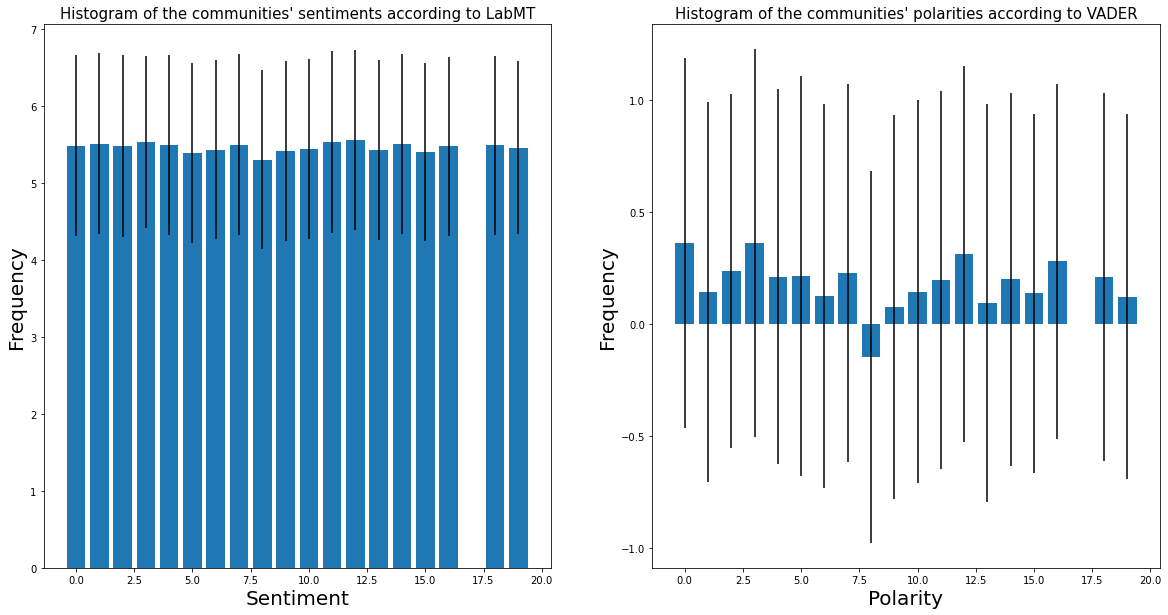

In [51]:
plt.figure(figsize = (20, 10))

plt.subplot(121)
plt.bar(range(0, Nc), com_sentiment, yerr = com_sentiment_std)
plt.xlabel('Sentiment', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title("Histogram of the communities' sentiments according to LabMT", fontsize = 15)

plt.subplot(122)
plt.bar(range(0, Nc), com_polarity, yerr = com_polarity_std)
plt.xlabel('Polarity', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
_=plt.title("Histogram of the communities' polarities according to VADER", fontsize = 15)

> * Explain the difference between the two methods and compare the results you have obtained above.

**ANSWER**:

According to the bar plot, there is more variation in the polarity using Vader than in the sentiment of labMT, with a clearly negative community that differ from the other (positive) communities, even though the standard deviations of the polarities using VADER are bigger. This can be explained by the fact that Vader better understand sentiment and its different intensity by taking into account punctuation, capitalization, degree modifiers etc.
<br> But overall, the two methods find the same 3 happiest and saddest communities, except for the 2nd happiest community. It means that even though VADER is more accurate in capturing the sentiment intensity of each community, LabMT still manages to differentiate between the sentiments of different communities, even though it is not perfect. 

> * What is the advantage of using a rule-based method over the dictionary-based approach?

**ANSWER**:

The rule-based method is a more nuanced and accurate approach: it is closer to how a human would interpret sentiment because it doesn't rely only on separate words but look at the context (punctuation and degree modifiers for example) to infer the sentiment intensity of a text.